Intermediate Metrics Keys:

Cluster-Specific Revenue Contributions: kmeans

In [1]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 999)

In [2]:
file_path = r'C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Aggregated Dataset.csv'
df = pd.read_csv(file_path)

# Preparing Data For K-Mean Clustering

K-Mean Clustering has many weaknesses. One of which is being sensitive to outliers. I confirmed in Excel that the dataset is very right skewed. Where there are many outliers on the high end of both Frequency, and Revenue. 

So I guess I'll deal with that now (._.)

#### Removing Outliers:

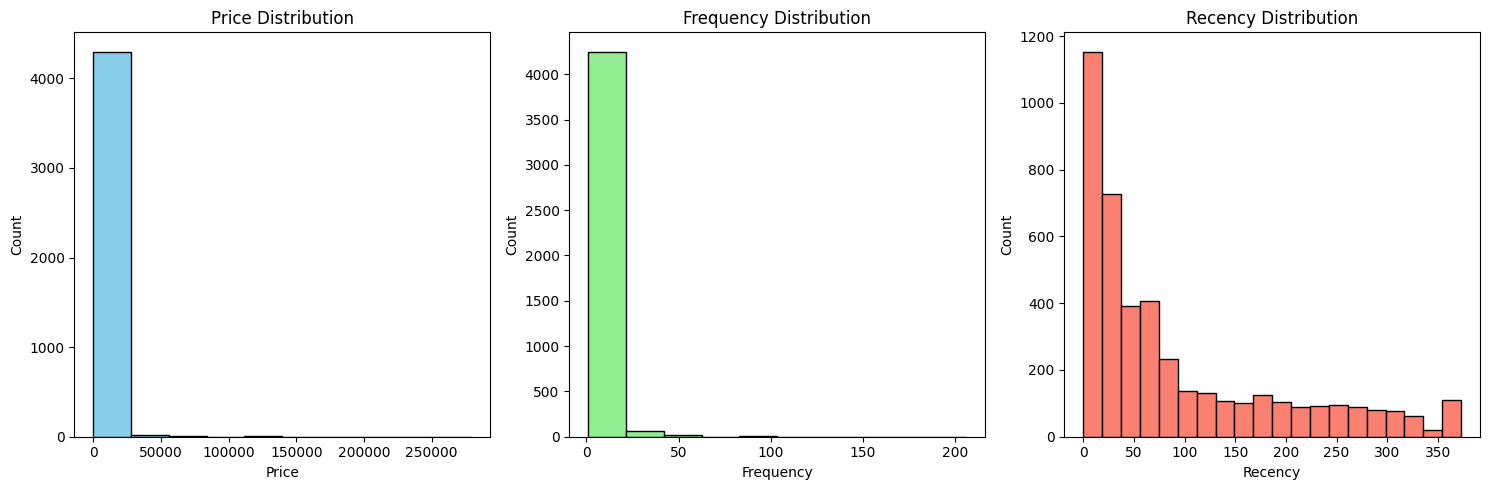

In [3]:
# Plotting to show the distribution of Values in the RFM variables.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Price'], bins=10, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

We can see a abnormal distribution for both Price and Frequency above

We want to remove the outliers from the general Clustering. So we are going to seperate the values into another dataset. 

We also do not want to remove the outlier completely. They are our most valuable customers afterall.

In [4]:
# We are removing the outliers that sit outside the 25th Quartile and the 75th Quartile.
# We want to keep the outliers for potential analysis. Because it would be important to know what our "Super Customers" behaviors are like as well.

# Also looking at the DF. There appears to only be a outlier customer in the 75th Quartile. We could just hard code them out, but that would be dumb.

# Setting the the Quartiles and the IQR
r_quantile_1 = df["Price"].quantile(0.25)
r_quantile_3 = df["Price"].quantile(0.75)
r_IQR = r_quantile_3 - r_quantile_1

# Getting the middle 50%
r_outlier = df[(df["Price"] > (r_quantile_3 + 1.5 * r_IQR))].copy()

r_outlier.describe()

,CustomerID,Price,Frequency,Basket_Size,Recency,Amount_Spent_per_Visit
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,15033.644706,12568.004118,16.647059,772.082353,25.181176,1281.677929
std,1797.854931,26097.899274,19.066978,4122.919428,47.091066,5630.745018
min,12346.000000,3622.680000,1.000000,28.000000,0.000000,130.120000
25%,13324.000000,4359.320000,8.000000,196.000000,3.000000,372.090000
50%,15005.000000,5891.610000,12.000000,302.000000,10.000000,523.350000
75%,16655.000000,9430.520000,19.000000,515.000000,24.000000,889.040000
max,18251.000000,279138.020000,206.000000,74215.000000,372.000000,84236.250000


In [5]:
# Same as above. But for Frequency.
f_quantile_1 = df["Frequency"].quantile(0.25)
f_quantile_3 = df["Frequency"].quantile(0.75)
f_IQR = f_quantile_3 - f_quantile_1

f_outlier = df[(df["Frequency"] > (f_quantile_3 + 1.5 * f_IQR))].copy()

f_outlier.describe()

,CustomerID,Price,Frequency,Basket_Size,Recency,Amount_Spent_per_Visit
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,15355.669065,14488.006691,23.089928,312.956835,13.629496,548.194173
std,1745.001840,30142.778160,21.166586,410.951171,30.387321,700.752697
min,12395.000000,1296.440000,12.000000,14.000000,0.000000,33.240000
25%,13880.250000,4197.772500,13.000000,128.250000,2.000000,247.095000
50%,15290.500000,6283.525000,17.000000,203.000000,6.000000,363.880000
75%,16781.250000,11040.835000,25.000000,312.000000,15.750000,509.630000
max,18283.000000,279138.020000,206.000000,3868.000000,372.000000,6228.230000


In [6]:
# Combining DF for both Price and Frequency outliers. And removing that from the overall DF to get only the "non_outliers"
outliers_indices = r_outlier.index.union(f_outlier.index)
non_outliers_df = df.drop(outliers_indices)

non_outliers_df.describe()

,CustomerID,Price,Frequency,Basket_Size,Recency,Amount_Spent_per_Visit
count,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000
mean,15323.852705,853.814416,2.755113,201.156873,100.475278,324.592255
std,1709.731704,794.608100,2.168124,213.859050,101.858246,257.978898
min,12348.000000,3.750000,1.000000,1.000000,0.000000,3.750000
25%,13850.500000,278.500000,1.000000,88.000000,22.000000,169.580000
50%,15333.000000,570.460000,2.000000,151.000000,59.000000,269.960000
75%,16798.000000,1187.005000,4.000000,254.000000,161.000000,393.225000
max,18287.000000,3619.170000,11.000000,4300.000000,373.000000,3528.340000


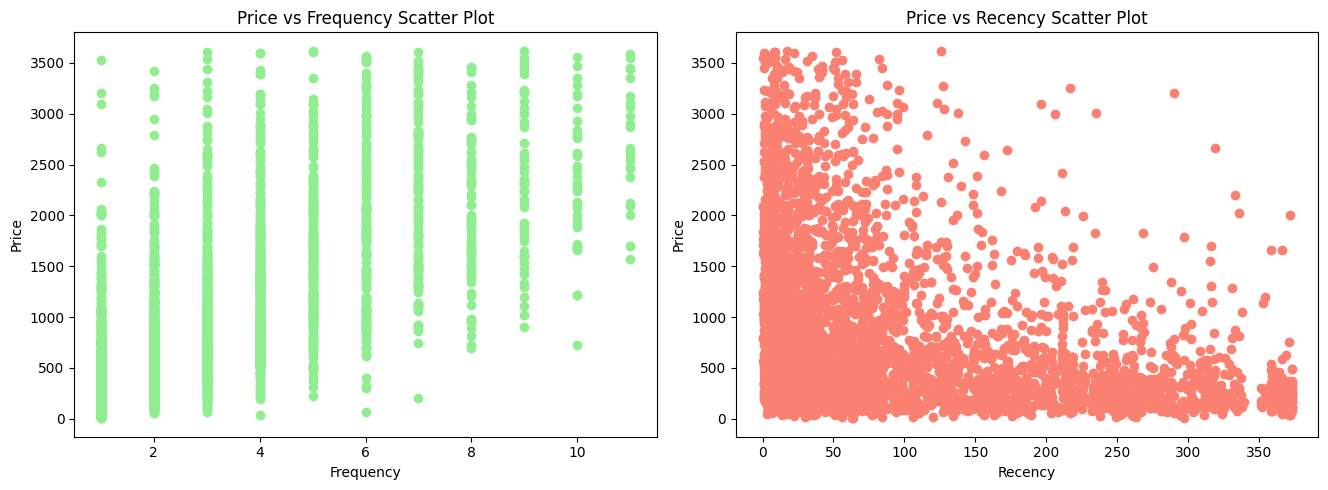

In [7]:
# Scatter plots to verify outliers removed
# List of column names (excluding Price, which we'll use on the y-axis)
columns = ['Frequency', 'Recency']
colors = ['lightgreen', 'salmon']

# Set up the figure size and a 1x3 grid layout
plt.figure(figsize=(20, 5))

# Loop through columns and plot each scatter plot
for i, (col, color) in enumerate(zip(columns, colors), start=1):
    plt.subplot(1, 3, i)
    plt.scatter(non_outliers_df[col], non_outliers_df['Price'], color=color)
    plt.title(f'Price vs {col} Scatter Plot')
    plt.xlabel(col)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

Another common pitfall of using Kmean Clustering is that larger values or ranges will influence the cluster more than smaller values. I am not adept with this specific topic and why this is the case. But I am aware that it is standard practice to Scale/Noramlize your data to overcome this shortcoming. At least if the guy on Youtube was correct.

#### Scaling Data:

In [8]:
# Scaling Data
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["Price", "Frequency", "Recency"]])
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=("MonetaryValue", "Frequency", "Recency"))

Determining Number of Clusters Using Elbow Method:

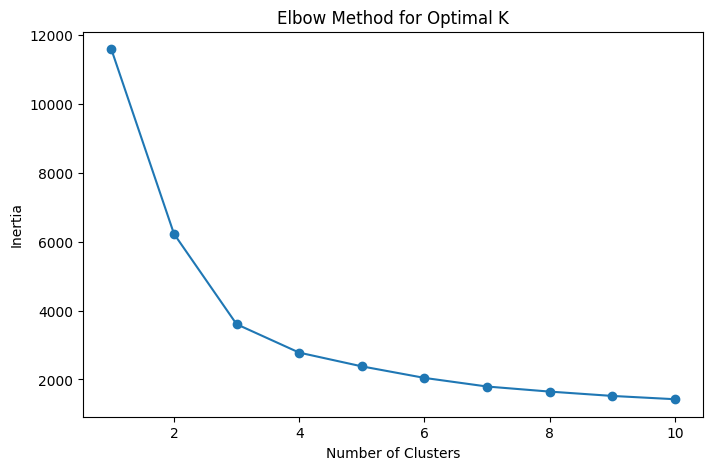

In [9]:
# Calculate inertia for different numbers of clusters
inertia = []
cluster_range = range(1, 11)  # Test clusters from 1 to 10
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_df)
    inertia.append(kmeans.inertia_)

# Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

#### Applying PCA and performing the K-Mean Cluster Algorithm

I have minimal working knowledge on applying a PCA before clustering. It apparently removed the noise from the cluster. This is just what Google suggested.

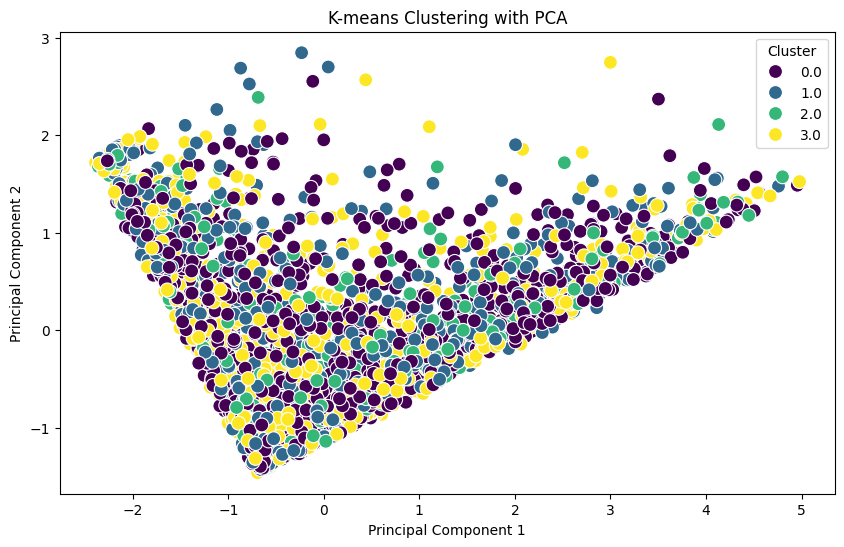

In [10]:
# Use a PCA graph to 
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce the data to 2 principal components
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_data_df)

# Run KMeans with the optimal number of clusters (e.g., 3 clusters found from the elbow method)
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
non_outliers_df['RMF Cluster'] = kmeans.fit_predict(scaled_data_df)

# Convert PCA result into a DataFrame for easier plotting
pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = non_outliers_df['RMF Cluster']

# Plot the clusters in the PCA-reduced space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [11]:
# Validating the Cluster. It doesn't look ideal, but it's expected from the unrealistic Kaggle dataset :(
# A Variance Ratio between 70%-90% generally provides a good summary of the data
print(pca.explained_variance_ratio_)

[0.67256654 0.23895205]


In [12]:
# Finding the Centers of each Cluster for each of the following in order: Price | Frequency | Recency
# And unscaling the Data to remove negative values.

original_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(original_centers)

[[4.25810627e+02 1.62467700e+00 5.63016796e+01]
 [3.78309735e+02 1.36652542e+00 2.58361229e+02]
 [2.42672046e+03 6.97510373e+00 3.12053942e+01]
 [1.25121101e+03 3.91001125e+00 4.72969629e+01]]


#### Defining the Clusters based on the Characteristics above

Price: Amount Spent
<br>
Frequency: Number of Purchases
<br>
Recency Days Since Last Purchase
<br>

Cluster 0 Price(425.81), Frequency(1.6), Recency(56.30)
<br>
Cluster 1 Price(378.31), Frequency(1.37), Recency(258.36)
<br>
Cluster 2 Price(2,426.72), Frequency(7), Recency(31.21)
<br>
Cluster 3 Price(1,251.21), Frequency(4), Recency(47.30)

In [13]:
# Save Cluster information to the imported CSV for Power BI analysis

try:
    non_outliers_df.to_csv(file_path, index=False)
    print('it work :))')
except PermissionError:
    print('it no work :(')

it work :))


#### Calculate Churn Rate Per Segment

In [14]:
churn_threshold = 180  # Define churn as no purchase in the last 180 days

# Add a churn column
non_outliers_df['Is_Churned'] = non_outliers_df['Recency'] > churn_threshold

non_outliers_df.describe()

#Group by segment to calculate churn rate
churn_rate = non_outliers_df.groupby('RMF Cluster')['Is_Churned'].mean() * 100
churn_rate = churn_rate.reset_index()
churn_rate.columns = ['RMF Cluster', 'Churn_Rate']

print(churn_rate)

   RMF Cluster  Churn_Rate
0            0    0.000000
1            1   87.711864
2            2    0.622407
3            3    2.022472


In [15]:
# Export Churn Rate Per Segment into a CSV File

# Create a DataFrame with your output
data = {
    'RMF Cluster': [0, 1, 2, 3],
    'Churn Rate': [0.000000, 87.711864, 0.622407, 2.022472]
}

churn_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
output_path = r'C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\churn_rate_per_segment.csv'
churn_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\churn_rate_per_segment.csv


#### Calculate Basket Size Per Segment

In [16]:
# Finding the Basket_Size per Segment. Same as above with Churn.
average_basket_size = non_outliers_df.groupby('RMF Cluster')['Basket_Size'].mean()
average_basket_size = average_basket_size.reset_index()
average_basket_size.columns = ['RMF Cluster', 'Average_Basket_Size']
print(average_basket_size)

   RMF Cluster  Average_Basket_Size
0            0           188.780220
1            1           164.265890
2            2           247.454357
3            3           236.725843


In [17]:
# Export Basket Size Per Segment into a CSV File

# Create a DataFrame with your output
data = {
    'RMF Cluster': [0, 1, 2, 3],
    'Average Basket Size': [188.780220, 164.265890, 247.454357, 236.725843]
}

basket_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
output_path = r'C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\basket_size_per_segment.csv'
basket_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\basket_size_per_segment.csv


#### Calculate Churn Over time

In [18]:
# Load Data
file_path = r'C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Cleaned Data Set.csv'
df = pd.read_csv(file_path)

# Convert InvoiceDate to datetime and group by Month
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Create a list of unique customers by month
monthly_customers = df.groupby('Month')['CustomerID'].unique()

# Identify Churned Customers
churned_customers = {}
for i in range(len(monthly_customers) - 1):
    current_month = monthly_customers.index[i]
    next_month = monthly_customers.index[i + 1]
    # Customers in current month but not in next month
    churned_customers[current_month] = set(monthly_customers[current_month]) - set(monthly_customers[next_month])

# Convert churned_customers to DataFrame
churn_data = pd.DataFrame({
    'Month': list(churned_customers.keys()),
    'Churned_Customers': [len(customers) for customers in churned_customers.values()]
})

# Add Total Customers and Calculate Churn Rate
churn_data['Total_Customers'] = [len(customers) for customers in monthly_customers[:-1]]
churn_data['Churn_Rate'] = (churn_data['Churned_Customers'] / churn_data['Total_Customers']) * 100

print(churn_data)

# Save the DataFrame to a CSV file
output_path = r'C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\churn_over_time.csv'
churn_data.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

      Month  Churned_Customers  Total_Customers  Churn_Rate
0   2010-12                561              884   63.461538
1   2011-01                479              739   64.817321
2   2011-02                467              757   61.690885
3   2011-03                672              973   69.064748
4   2011-04                487              853   57.092614
5   2011-05                644             1054   61.100569
6   2011-06                625              990   63.131313
7   2011-07                560              946   59.196617
8   2011-08                510              933   54.662379
9   2011-09                772             1259   61.318507
10  2011-10                745             1361   54.739162
11  2011-11               1290             1660   77.710843
Data saved to C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\churn_over_time.csv


#### Calculate Basket Size Over time

In [19]:
# Create a new DataFrame by merging

updated_df = df.merge(non_outliers_df[['CustomerID', 'Basket_Size']], 
              on=['CustomerID'], 
              how='left')

# Convert InvoiceDate to datetime and group by Month
updated_df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
updated_df['Month'] = updated_df['InvoiceDate'].dt.to_period('M')

# Calculate the average basket size per customer for each month
monthly_basket_size = updated_df.groupby(['Month', 'CustomerID'])['Basket_Size'].mean().reset_index()

# Calculate the overall average basket size for each month
monthly_avg_basket_size = monthly_basket_size.groupby('Month')['Basket_Size'].mean().reset_index()
monthly_avg_basket_size.rename(columns={'Basket_Size': 'Average_Basket_Size'}, inplace=True)

# Calculate the change in average basket size month-over-month
monthly_avg_basket_size['Basket_Size_Change'] = monthly_avg_basket_size['Average_Basket_Size'].diff()

print(monthly_avg_basket_size)

# Save the DataFrame to a CSV file
output_path = r'C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\basket_size_over_time.csv'
monthly_avg_basket_size.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

      Month  Average_Basket_Size  Basket_Size_Change
0   2010-12           170.931894                 NaN
1   2011-01           179.482030            8.550136
2   2011-02           191.346304           11.864274
3   2011-03           187.221893           -4.124410
4   2011-04           183.018739           -4.203154
5   2011-05           192.917469            9.898730
6   2011-06           191.315634           -1.601835
7   2011-07           207.012500           15.696866
8   2011-08           205.555024           -1.457476
9   2011-09           213.917204            8.362180
10  2011-10           205.802871           -8.114333
11  2011-11           196.661491           -9.141380
12  2011-12           196.786070            0.124579
Data saved to C:\Users\Computer\Desktop\Github\03 Customer Behavior and Segmentation using Kmeans\Data\Feature Engineering Datasets\basket_size_over_time.csv
